# BAYER - VIGILOO --> Control de Interfaces y Consistencia de DATOS

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import datetime
import json

def obtener_enlaces(url):
    # Realizar la petición HTTP a la página web
    respuesta = requests.get(url)
    # Si la petición fue exitosa, procesar el contenido
    if respuesta.status_code == 200:
        soup = BeautifulSoup(respuesta.content, 'html.parser')
        # Extraer todos los elementos <a> de la página
        enlaces = soup.find_all('a', href=True)
        # Crear una lista para almacenar los datos
        datos = []
        # Recorrer cada enlace y almacenar la información necesaria
        for enlace in enlaces:
            # Extraer el href del enlace
            href = enlace['href']
            # Extraer el texto del enlace, que es el nombre del archivo
            texto = enlace.text
            # Intentar extraer las observaciones que están en el contenido antes del enlace
            # Esto asume que el texto de observaciones está justo antes del enlace
            observaciones = enlace.previous_sibling
            if observaciones:
                observaciones = observaciones.strip()  #Remueve los espacios al principio y al final de la línea
                # Dividir las observaciones en partes
                partes = observaciones.split("   ")
                #print(partes)
                # Extraer la fecha y la hora (primeras dos partes)
                fecha_hora = ' '.join(partes[:1])
                #print(fecha_hora)
                # Extraer el tamaño (última parte)
                tamaño = partes[-1]
                #print(tamaño)
            else:
                fecha_hora = "No disponible"
                tamaño = "No disponible"
            # Añadir a la lista como una tupla
            datos.append((texto, "http://rtv-b2b-api-logs.vigiloo.net" + href, fecha_hora, tamaño))    # datos.append((texto, url + href, fecha_hora, tamaño))
        # Convertir la lista en un DataFrame
        df = pd.DataFrame(datos, columns=['NombreArchivo', 'URL', 'FechaHora', 'Tamaño'])
        df.drop(0,axis=0)
        # Convertir la columna 'FechaHora' a tipo datetime
        df['FechaHora'] = pd.to_datetime(df['FechaHora'], dayfirst=False, format='%m/%d/%Y %I:%M %p',errors='coerce') 
        # Convertir la columna 'Tamaño' a tipo numérico
        df['Tamaño'] = pd.to_numeric(df['Tamaño'], errors='coerce')
        df['Embarque'] = df['NombreArchivo'].str.extract(r'-(\d+)\.log')
        df.drop(0,axis=0, inplace=True)  # Borro la Primera línea que apunta al directorio padre        
        return df
    else:
        return "Error al acceder a la página"

### 1) Dataframe con el TOTAL de los archivos existentes de archivos de Log

In [2]:
# URL de la página de donde se desean extraer los enlaces
url = "http://rtv-b2b-api-logs.vigiloo.net/LoadUpload/"
archivos_df = obtener_enlaces(url)
if isinstance(archivos_df, pd.DataFrame):
   print(archivos_df.head(1))
else:
   print("Error")

                      NombreArchivo  \
1  638529154316625586-834309642.log   

                                                 URL           FechaHora  \
1  http://rtv-b2b-api-logs.vigiloo.net/LoadUpload... 2024-06-02 09:57:00   

   Tamaño   Embarque  
1   906.0  834309642  


In [3]:
# FILTRAR Archivos_df y generar subset en archivo SALIDA
# Inicio Nueva Nomenclatura de Archivos 01/18/2024

fecha_inicio = datetime.datetime(year=2025,month=1,day=1)

entrada = archivos_df[(archivos_df['FechaHora'] >=fecha_inicio)]
#salida.dropna()
# print(filtered_df)


In [4]:
entrada.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2060 entries, 12852 to 14911
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   NombreArchivo  2060 non-null   object        
 1   URL            2060 non-null   object        
 2   FechaHora      2060 non-null   datetime64[ns]
 3   Tamaño         2060 non-null   float64       
 4   Embarque       2060 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 96.6+ KB


In [5]:
# FILTRADO y ORDENADO del dataframe para procesar secuencialmente

graficar = entrada.sort_values(by=['Embarque', 'FechaHora'])

In [6]:
# Recuento de la Cantidad de Archvios por Minuto
agruparD = graficar['FechaHora'].dt.floor('D').value_counts()

#agruparD = graficar['FechaHora'].dt.floor('min').value_counts()

In [7]:
#agruparD["Fecha"] = [date.strftime('%Y-%m-%d') for date in  agruparD.index]
agruparD['Fecha'] = pd.to_datetime(agruparD.index, format = '%Y-%m-%d')

In [8]:
agruparD.info()

<class 'pandas.core.series.Series'>
Index: 29 entries, 2025-01-27 00:00:00 to Fecha
Series name: count
Non-Null Count  Dtype 
--------------  ----- 
29 non-null     object
dtypes: object(1)
memory usage: 464.0+ bytes


In [ ]:
print(graficar.head())
print(graficar.info())


In [ ]:
print(graficar.dtypes)


In [ ]:
print(agruparD)


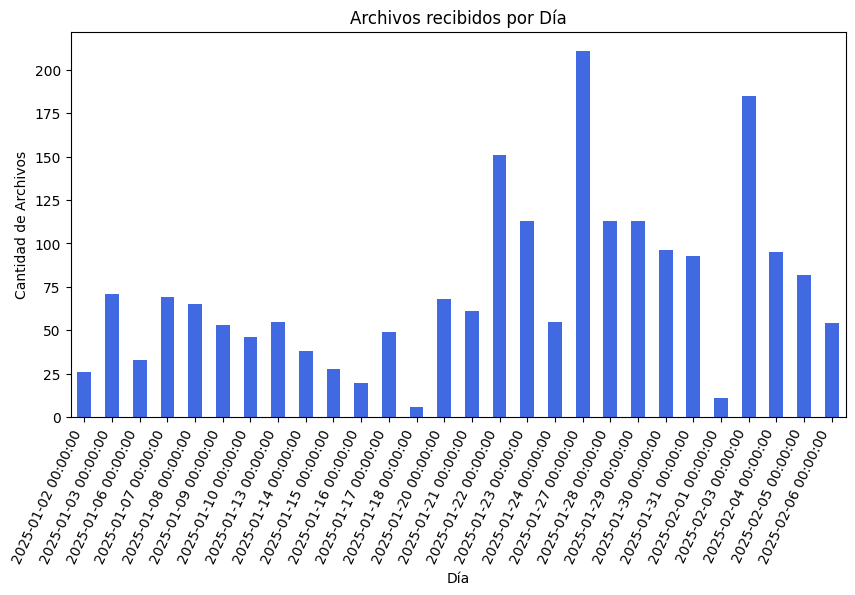

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Verificar si la columna FechaHora es válida
if 'FechaHora' not in graficar.columns:
    raise ValueError("La columna 'FechaHora' no existe en el DataFrame.")

# Convertir a datetime si es necesario
if not pd.api.types.is_datetime64_any_dtype(graficar['FechaHora']):
    graficar['FechaHora'] = pd.to_datetime(graficar['FechaHora'], errors='coerce')

# Filtrar filas con fechas no válidas
graficar = graficar.dropna(subset=['FechaHora'])

# Agrupar por día y contar archivos
agruparD = graficar['FechaHora'].dt.floor('D').value_counts().sort_index()

# Verificar si hay datos para graficar
if agruparD.empty:
    print("⚠️ No hay datos disponibles para graficar.")
else:
    # Crear figura
    plt.figure(figsize=(10, 5))  # Tamaño más amplio

    # Graficar como barra
    agruparD.plot(kind='bar', color='royalblue')

    # Configuración de etiquetas
    plt.title('Archivos recibidos por Día')
    plt.xlabel('Día')
    plt.ylabel('Cantidad de Archivos')

    # Rotar etiquetas del eje X
    plt.xticks(rotation=65, ha='right')

    # Mostrar gráfico
    plt.show()



## Explicación del Formato

%m: Representa el mes como un número con dos dígitos (01 a 12).

%d: Representa el día del mes como un número con dos dígitos (01 a 31).

%Y: Representa el año con cuatro dígitos.

%I: Representa la hora en formato de 12 horas (01 a 12).

%M: Representa los minutos.

%p: Representa AM o PM.

En nuestro caso como la fecha tiene los Dias y los Meses sin PADD hay que utilizar la siguiente opción

### pd.to_datetime(salida['FechaHora'], dayfirst=False).dt.strftime('%m/%d/%Y %I:%M %p')


https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior

https://pandas.pydata.org/pandas-docs/version/1.0.1/reference/api/pandas.to_datetime.html

https://github.com/pandas-dev/pandas/issues/3341

In Linux "#" is replaced by "-":
%-d, %-H, %-I, %-j, %-m, %-M, %-S, %-U, %-w, %-W, %-y, %-Y
In Windows "-" is replaced by "#":
%#d, %#H, %#I, %#j, %#m, %#M, %#S, %#U, %#w, %#W, %#y, %#Y

#Linux
mydatetime.strftime('%-m/%d/%Y %-I:%M%p')
#Windows
mydatetime.strftime('%#m/%d/%Y %#I:%M%p')
Source: https://msdn.microsoft.com/en-us/library/fe06s4ak.aspx

## Procesar un registro JSON

* https://brightdata.es/blog/procedimientos/parse-json-data-with-python
* https://docs.python.org/3/tutorial/datastructures.html#dictionaries
* https://docs.python.org/3/tutorial/datastructures.html#more-on-lists


In [10]:
# Busco un registro para probar

reg=2
url = entrada.iloc[reg]['URL']

print(url)
print('Archivo : ',entrada.iloc[reg]['NombreArchivo'])
print('Embarque: ',entrada.iloc[reg]['Embarque'])
print('Fecha   : ',entrada.iloc[reg]['FechaHora'])
print('Tamaño  : ',entrada.iloc[reg]['Tamaño'])
embarque = pd.read_json(url)

http://rtv-b2b-api-logs.vigiloo.net/LoadUpload/638714089020955380-834719557.log
Archivo :  638714089020955380-834719557.log
Embarque:  834719557
Fecha   :  2025-01-02 11:01:00
Tamaño  :  353.0


### Ejemplo de Uso

https://stackoverflow.com/questions/74118717/create-new-dataframe-with-json-objects-from-another-dataframe#:~:text=Solution%20using%20pandas&text=It%20provides%20a%20DataFrame%20object,dataframe%20with%20the%20original%20one



## Procesar El archivo SALIDA identificando los JSON

### PARAMETROS para la CONSULTA.

#### Comienza el proceso

In [14]:
# Extraer valores únicos de la columna 'Embarque' para usar en Query SI QUIERO PROCESAR TODO
embarques = entrada['Embarque'].unique()

# Formatear los valores entre apóstrofes y separados por comas
#REGISTROS = ', '.join(f"'{embarque}'" for embarque in embarques)

REGISTROS = ','.join(f"{embarque}" for embarque in embarques)

REGISTROS = tuple(REGISTROS.split(','))


In [15]:
print(REGISTROS)

('834719165', '834719066', '834719557', '834719361', '834719166', '834719248', '834719167', '834719172', '834719362', '834719186', '834719418', '834721987', '834722136', '834722135', '834721635', '834722393', '834722181', '834722185', '834722191', '834722276', '834722395', '834722165', '834722166', '834722167', '834724659', '834724660', '834722397', '834624674', '834651681', '834672688', '834724944', '834724904', '834724968', '834725157', '834725769', '834725933', '834725934', '834725936', '834725937', '834725941', '834725943', '834725947', '834725948', '834725949', '834725942', '834725944', '834725945', '834725946', '834725935', '834725877', '834725891', '834725850', '834725932', '834725878', '834725840', '834725879', '834725880', '834725930', '834725931', '834725834', '834725839', '834725822', '834725828', '834725831', '834725830', '834725838', '834725876', '834725833', '834725832', '834725817', '834725818', '834725816', '834725812', '834725811', '834683368', '834728402', '834728405'

In [16]:
type(REGISTROS)

tuple

In [11]:
# PARAMETROS SI QUIERO CONSULTAS REGISTROS RECIBIDOSA EN EL ENVÍO --> SOBRE ESCRIBIR REGISTROS

REGISTROS=('834806365',
'834806366',
'834806367',
'834806368',
'834806369',
'834806370',
'834806970',
'834810205',
'834810206',
'834810590',
'834810602',
'834810603',
'834810611',
'834810664',
'834810672',
'834810673'
)

In [12]:
# FUNCIONES PARA LEER ARCHIVOS JSON
import requests
import json

def procesar_entregas_desde_url(url, modo='imprimir'):
    # Descargar el contenido del archivo JSON desde la URL
    respuesta = requests.get(url)
    respuesta.raise_for_status()  # Esto lanzará una excepción si ocurre un error

    # Leer el contenido JSON
    datos = respuesta.json()    
    resultados = []
    
    # Leer Datos de la Cabecera    
    resultado = f"\nOrigen: {datos['LogisticGroupCode']},  Embarque: {datos['Id']}, Date: {datos['Date']}, Carrier: {datos['CarrierName']}\n"
    resultados.append(resultado)
    # Imprimir la información si el modo es 'imprimir'
    if modo == 'imprimir':
        print(resultado)

    # Procesar y almacenar la información en una lista
    for stop in datos['StopList']:
        # Verificar que la parada tenga entregas
        if stop['OperationType'] == 'Dropped' and stop.get('Deliveries'):
            for delivery in stop['Deliveries']:
                delivery_number = delivery['DeliveryNumber']
                location = stop['LocationName']
                for item in delivery['Items']:
                    material_name = item['MaterialName']
                    batch = item.get('Batch', 'N/A')
                    qty = item['Qty']
                    
                    resultado = f"   DeliveryNumber: {delivery_number}, LocationName: {location}, MaterialName: {material_name}, Batch: {batch}, Qty: {qty}"
                    resultados.append(resultado)

                    # Imprimir la información si el modo es 'imprimir'
                    if modo == 'imprimir':
                        print(resultado)
    
    # Devolver los resultados si el modo es 'devolver'
    if modo == 'devolver':
        return resultados

    # Almacenar los resultados en un archivo si el modo es 'almacenar'
    if modo == 'almacenar':
        with open('resultados.txt', 'a', encoding="utf-8") as archivo_salida:
            for resultado in resultados:
                archivo_salida.write(resultado + '\n')
            archivo_salida.close()
                


# Ejemplo para validar el uso de la función
# url = 'http://rtv-b2b-api-logs.vigiloo.net/LoadUpload/638508724764465417-834195574.log'
# procesar_entregas_desde_url(url, modo='imprimir')


#### Explicación
* Leer el archivo JSON: Utilizamos json.load() para cargar el contenido del archivo JSON en una variable datos.
* Procesar las entregas: Iteramos sobre la lista de paradas (StopList). Para cada parada, obtenemos la lista de entregas (Deliveries).
* Extraer y mostrar la información: Para cada entrega, extraemos DeliveryNumber, LocationName, MaterialName, Batch, y Qty, y luego imprimimos esta información en el formato deseado.
* Función versátil: La función procesar_entregas permite imprimir, devolver o almacenar la información según el modo especificado.

##### Ejemplo de uso de la función
procesar_entregas('archivo.json', modo='imprimir')

Utiliza los PARAMETROS ingresados anteriormente

In [13]:
# FILTRADO y ORDENADO del dataframe para procesar secuencialmente

resumen = entrada.loc[entrada["Embarque"].isin(REGISTROS)]
salida = resumen.sort_values(by=['Embarque', 'FechaHora'])

In [14]:
salida.info()


<class 'pandas.core.frame.DataFrame'>
Index: 109 entries, 14562 to 14857
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   NombreArchivo  109 non-null    object        
 1   URL            109 non-null    object        
 2   FechaHora      109 non-null    datetime64[ns]
 3   Tamaño         109 non-null    float64       
 4   Embarque       109 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 5.1+ KB


In [15]:
# Recuento de la Cantidad de Archvios por Minuto
grouped = salida['FechaHora'].dt.floor('min').value_counts()

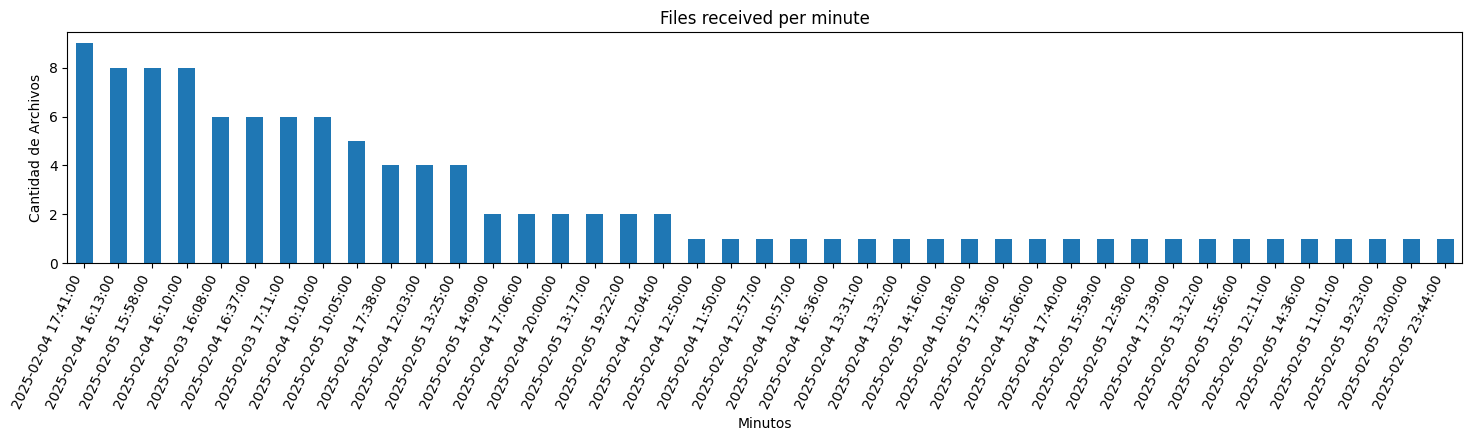

In [16]:
import matplotlib.pyplot as plt

# Creación del gráfico
plt.figure(figsize=(18, 3)) # Aumenta el ancho aquí
grouped.plot(kind='bar') 
plt.title('Files received per minute') 
plt.xlabel('Minutos') 
plt.ylabel('Cantidad de Archivos')
plt.xticks(rotation=65, ha='right')  #Rotar el ángulo de las etiquetas x
plt.show()


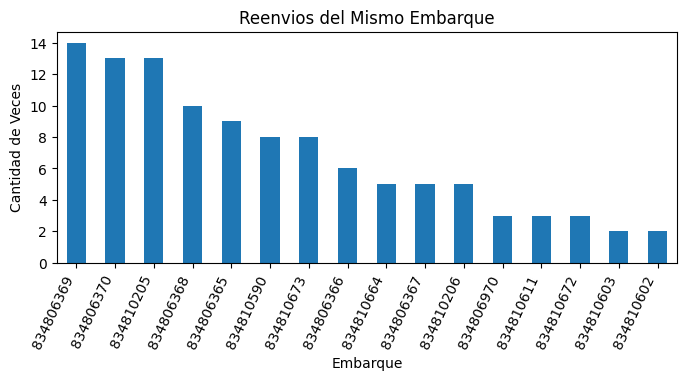

In [17]:
reenvios = salida['Embarque'].value_counts()

# Creación del gráfico
plt.figure(figsize=(8, 3)) # Aumenta el ancho aquí
reenvios.plot(kind='bar', width=0.5) # Ajuste la anchura de las barras aquí
plt.title('Reenvios del Mismo Embarque')
plt.xlabel('Embarque')
plt.ylabel('Cantidad de Veces')
plt.xticks(rotation=65, ha='right')

plt.show()


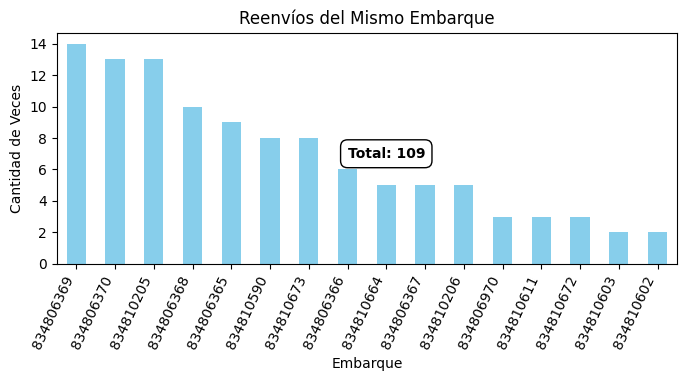

In [18]:
reenvios = salida['Embarque'].value_counts()

# Creación del gráfico
plt.figure(figsize=(8, 3))  # Ajusta el tamaño del gráfico
reenvios.plot(kind='bar', width=0.5, color='skyblue')  # Color opcional

# Agregar título y etiquetas
plt.title('Reenvíos del Mismo Embarque')
plt.xlabel('Embarque')
plt.ylabel('Cantidad de Veces')
plt.xticks(rotation=65, ha='right')

# Calcular el total de embarques
total_embarques = reenvios.sum()

# Posicionar el label flotante en el centro del gráfico
plt.text(
    len(reenvios) / 2,  # Posición horizontal en el centro
    reenvios.max() / 2,  # Posición vertical en el centro de las barras
    f'Total: {total_embarques}', 
    fontsize=10, color='black', fontweight='bold',
    ha='center', va='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5')
)

# Mostrar el gráfico
plt.show()


In [19]:
# RUTINA PARA IMPRIMIR SALIDAS por la Terminal

for i in range(len(salida)):
    if salida.iloc[i]['Embarque'] in (REGISTROS):
        print('----------------------------------------------------------------')
        print('Embarque: ',salida.iloc[i]['Embarque'])
        url = salida.iloc[i]['URL']
        print(f'Archivo: ',salida.iloc[i]['FechaHora'],url)
        # Procesar cada Embarque
        resultado = procesar_entregas_desde_url(url, modo='imprimir')


----------------------------------------------------------------
Embarque:  834806365
Archivo:  2025-02-03 16:08:00 http://rtv-b2b-api-logs.vigiloo.net/LoadUpload/638741920933631834-834806365.log

Origen: SAPP08,  Embarque: 834806365, Date: 2025-02-07T14:00:00Z, Carrier: ROBINSON LOGISTICS S A

   DeliveryNumber: 5011751171, LocationName: HIJOS DE DANIEL E YOUNG SA, MaterialName: RUP CONTROLMAX,AR,64x15KG BOX, Batch: None, Qty: 210.0
   DeliveryNumber: 5011751172, LocationName: HIJOS DE DANIEL E YOUNG SA, MaterialName: RUP CONTROLMAX,AR,64x15KG BOX, Batch: None, Qty: 165.0
   DeliveryNumber: 5011751173, LocationName: HIJOS DE DANIEL E YOUNG SA, MaterialName: RUP CONTROLMAX,AR,64x15KG BOX, Batch: None, Qty: 150.0
   DeliveryNumber: 5011751174, LocationName: HIJOS DE DANIEL E YOUNG SA, MaterialName: RUP CONTROLMAX,AR,64x15KG BOX, Batch: None, Qty: 210.0
   DeliveryNumber: 5011751176, LocationName: HIJOS DE DANIEL E YOUNG SA, MaterialName: RUP CONTROLMAX,AR,64x15KG BOX, Batch: None, Qty: 

## ANÁLISIS SOLO DE LOS FALTANTES o INCOMPLETOS

In [20]:
# PARAMETROS SI QUIERO CONSULTAS REGISTROS RECIBIDOSA EN EL ENVÍO --> SOBRE ESCRIBIR REGISTROS

FALTANTES=('834806365',
'834806366',
'834806367',
'834806368',
'834806970',
'834810205',
'834810206',
'834810590',
'834810673'
)

In [21]:
# FILTRADO y ORDENADO del dataframe para procesar secuencialmente

faltan = entrada.loc[entrada["Embarque"].isin(FALTANTES)]
fallaron = faltan.sort_values(by=['Embarque', 'FechaHora'])

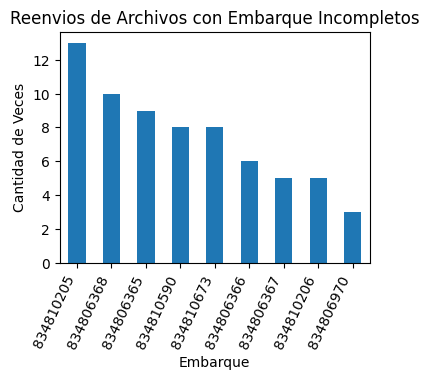

In [22]:
# Recuento de la Cantidad de Archvios por Minuto
grouped = fallaron['FechaHora'].dt.floor('min').value_counts()

reenvios = fallaron['Embarque'].value_counts()

# Creación del gráfico
plt.figure(figsize=(4, 3)) # Aumenta el ancho aquí
reenvios.plot(kind='bar', width=0.5) # Ajuste la anchura de las barras aquí
plt.title('Reenvios de Archivos con Embarque Incompletos')
plt.xlabel('Embarque')
plt.ylabel('Cantidad de Veces')
plt.xticks(rotation=65, ha='right')

plt.show()


In [23]:
# DETALLE de los ARCHIVOS JSON con FALTANTES
# import requests
# import json

# RUTINA PARA IMPRIMIR SALIDAS por la Terminal

for i in range(len(salida)):
    if salida.iloc[i]['Embarque'] in (FALTANTES):
        print('----------------------------------------------------------------')
        print('Embarque: ',salida.iloc[i]['Embarque'])
        url = salida.iloc[i]['URL']
        print(f'Archivo: ',salida.iloc[i]['FechaHora'],url)
        # Procesar cada Embarque
        resultado = procesar_entregas_desde_url(url, modo='imprimir')
                

----------------------------------------------------------------
Embarque:  834806365
Archivo:  2025-02-03 16:08:00 http://rtv-b2b-api-logs.vigiloo.net/LoadUpload/638741920933631834-834806365.log

Origen: SAPP08,  Embarque: 834806365, Date: 2025-02-07T14:00:00Z, Carrier: ROBINSON LOGISTICS S A

   DeliveryNumber: 5011751171, LocationName: HIJOS DE DANIEL E YOUNG SA, MaterialName: RUP CONTROLMAX,AR,64x15KG BOX, Batch: None, Qty: 210.0
   DeliveryNumber: 5011751172, LocationName: HIJOS DE DANIEL E YOUNG SA, MaterialName: RUP CONTROLMAX,AR,64x15KG BOX, Batch: None, Qty: 165.0
   DeliveryNumber: 5011751173, LocationName: HIJOS DE DANIEL E YOUNG SA, MaterialName: RUP CONTROLMAX,AR,64x15KG BOX, Batch: None, Qty: 150.0
   DeliveryNumber: 5011751174, LocationName: HIJOS DE DANIEL E YOUNG SA, MaterialName: RUP CONTROLMAX,AR,64x15KG BOX, Batch: None, Qty: 210.0
   DeliveryNumber: 5011751176, LocationName: HIJOS DE DANIEL E YOUNG SA, MaterialName: RUP CONTROLMAX,AR,64x15KG BOX, Batch: None, Qty: 

In [33]:
# RUTINA PARA GRABAR en Archivo las SALIDAS 

with open('./data/resultados.txt', 'a', encoding="utf-8") as f:
    f.write(f"PROCESO DE INTEFACES desde resultado {fecha_inicio}" + '\n')
    f.close()

for i in range(len(salida)):
    if salida.iloc[i]['Embarque'] in (FALTANTES):
        with open('resultados.txt', 'a', encoding="utf-8") as f:
            f.write('\n----------------------------------------------------------------\n')
            f.write(f"Embarque: '{salida.iloc[i]['Embarque']}")
            url = salida.iloc[i]['URL']
            f.write(f"Archivo:  {salida.iloc[i]['FechaHora']} - {url}")
            f.close()
        # Procesar cada Embarque
        resultado = procesar_entregas_desde_url(url, modo='almacenar')

### Otras Alternativas para Analizar JSON Complejos

https://www.ionos.es/digitalguide/paginas-web/desarrollo-web/python-jsonpath/#:~:text=Para%20que%20Python%20pueda%20leer,%E2%80%9D%20o%20%E2%80%9Cload()%E2%80%9D.



In [34]:
salida.head(10)

,NombreArchivo,URL,FechaHora,Tamaño,Embarque
14152,638736758076153769-834791208.log,http://rtv-b2b-api-logs.vigiloo.net/LoadUpload...,2025-01-28 16:43:00,2316.0,834791208
14162,638736778711744735-834791208.log,http://rtv-b2b-api-logs.vigiloo.net/LoadUpload...,2025-01-28 17:17:00,3768.0,834791208
14183,638737416840715890-834791208.log,http://rtv-b2b-api-logs.vigiloo.net/LoadUpload...,2025-01-29 11:01:00,3824.0,834791208
14243,638737554240199365-834791208.log,http://rtv-b2b-api-logs.vigiloo.net/LoadUpload...,2025-01-29 14:50:00,3824.0,834791208
14265,638737589854658694-834791208.log,http://rtv-b2b-api-logs.vigiloo.net/LoadUpload...,2025-01-29 15:49:00,2348.0,834791208
14153,638736758076313927-834791214.log,http://rtv-b2b-api-logs.vigiloo.net/LoadUpload...,2025-01-28 16:43:00,854.0,834791214
14164,638736778723210019-834791214.log,http://rtv-b2b-api-logs.vigiloo.net/LoadUpload...,2025-01-28 17:17:00,5140.0,834791214
14189,638737418002727210-834791214.log,http://rtv-b2b-api-logs.vigiloo.net/LoadUpload...,2025-01-29 11:03:00,5225.0,834791214
14192,638737466678987801-834791214.log,http://rtv-b2b-api-logs.vigiloo.net/LoadUpload...,2025-01-29 12:24:00,862.0,834791214
14151,638736758076038192-834791218.log,http://rtv-b2b-api-logs.vigiloo.net/LoadUpload...,2025-01-28 16:43:00,8782.0,834791218


In [35]:
# EXPORTAR los datos a EXCEL 
salida.to_excel("./salida.xlsx")

## 1) Generar Conexión con SQL SERVER

In [ ]:
# CONECTAR con SERVIDOR SQL SERVER

import pyodbc
from dotenv import dotenv_values

secrets = dotenv_values(".env")
local_secrets = dotenv_values(".env.dev")

SERVER = secrets["SERVIDOR"]
DATABASE = secrets["DATABASE"]
USERNAME = secrets["USUARIO"]
PASSWORD = secrets["CONTRASENA"]
PORT = secrets["PUERTO"]
DRIVER = secrets["DRIVER"]
OPTIONS= secrets["OPTION"]

connectionString = f'DRIVER={DRIVER};SERVER={SERVER};DATABASE={DATABASE};UID={USERNAME};PWD={PASSWORD};{OPTIONS}'
print(connectionString)
conn = pyodbc.connect(connectionString) 

#    DRIVER={ODBC Driver 18 for SQL Server};SERVER=213.134.40.73,9595;DATABASE=seamtrack;UID=eduardo.ettlin@vigiloo.com.ar;PWD=Aladelta10$;encrypt=no
#    DRIVER={ODBC Driver 18 for SQL Server};SERVER=username;DATABASE=secret;UID=eduar;PWD=Aladelta10$;encrypt=no

## 2) Extraerlos Datos procesados que están en SQL SERVER

In [34]:
# Armar la Consulta con sus PARAMETROS

SQL_QUERY = f"""
SELECT   DISTINCT     
A.[RefId] as EMBARQUE
,D.RefId as DELIVERY
,A.[Date] as FECHA
,D.[PurchaseOrderIdRef] as PEDIDO
,D.[DestinationCode]
,D.[DestinationName]
,E.[MaterialCode]
,E.[MaterialName]
,E.[Batch]
,STR(E.[Qty],6) as QTY
,A.[LogisticGroupId]

FROM [seamtrack].[vigiloo].[Shipment] A
LEFT JOIN [seamtrack].[vigiloo].[ShipmentDestination] B
ON B.[ShipmentId] = A.Id
LEFT JOIN [seamtrack].[vigiloo].[Delivery] D
ON D.[ShipmentId] = A.Id
LEFT JOIN [seamtrack].[vigiloo].[DeliveryItem] E
ON E.[DeliveryId] = D.Id
    
WHERE A.[RefId] IN {REGISTROS}
ORDER BY A.RefId,D.RefId, D.[DestinationCode],E.[MaterialCode];
"""


In [ ]:
print(SQL_QUERY)

In [ ]:
# Ejecutar la Consulta
cursor = conn.cursor()
cursor.execute(SQL_QUERY)


In [37]:
records = cursor.fetchall()

In [ ]:
# IMPRIMIR Resultados de la Consulta
for r in records:
    print(f"{r.EMBARQUE}\t{r.DELIVERY}\t{r.FECHA}\t{r.DestinationCode}\t{r.DestinationName}\t{r.MaterialName}\t{r.Batch}\t{r.QTY}\t{r.LogisticGroupId}")

In [39]:
# Generar DATAFRAME con los resultados de las consultas
df = pd.DataFrame((tuple(t) for t in records)) 
df.columns = ['EMBARQUE','DELIVERY','FECHA','PEDIDO','DestinationCode','DestinationName','MaterialCode','MaterialName','Batch','QTY','LogisticGroupId']

In [40]:
# Eliminar Registros con datos Nulos
df.dropna(subset=['EMBARQUE','DELIVERY'], inplace=True)

In [41]:
# Adecuar el Grupo Logístico
df["LogisticGroupId"] = df["LogisticGroupId"].replace(
    { "75247427-34FD-41A3-B7E0-F0B8312EADA8": "Monsanto", "F21EE1F9-4823-42B4-AD40-8C81F2847818": "BAYER" })

In [ ]:
df.head(20)

In [ ]:
df.info()

In [61]:
# EXPORTAR DATOS EN FORMATO EXCEL

df.to_excel("./data/SQLServer.xlsx")

## CONTROL COMPLETO de TODAS LAS INTERFACES

#### Verificar si todo lo que está en LoadUpload EXISTE en las bases de VIGILOO

In [ ]:
print(len(REGISTROS))

In [46]:
# Armar la Consulta con sus PARAMETROS

SQL_QUERY = f"""
SELECT DISTINCT     
       A.[RefId] as EMBARQUE
FROM [seamtrack].[vigiloo].[Shipment] A
"""

In [ ]:
# Ejecutar la Consulta
cursor = conn.cursor()
cursor.execute(SQL_QUERY)

In [48]:
records = cursor.fetchall()

In [49]:
# Generar DATAFRAME con los resultados de las consultas
sqldf = pd.DataFrame((tuple(t) for t in records)) 
sqldf.columns = ['EMBARQUE']

In [ ]:
sqldf.head()

### Comparación de DATAFRAMES

#### 1) Archivos en Interfaces que NO ESTAN en la base de Datos. 

In [51]:
# UTILIZANDO LEFT JOIN
# Realizar un merge left con un indicador que muestre de dónde vienen los datos
merged_df = pd.merge(df, sqldf, on='EMBARQUE', how='left', indicator=True)

# Filtrar los registros que solo existen en el DataFrame 'df'
result_df = merged_df[merged_df['_merge'] == 'left_only']

# Seleccionar solo las columnas del DataFrame original 'df'
result_df = result_df[df.columns]


In [ ]:
print("Cantidad de INTEFACES NO PROCESADAS: ",len(result_df))

In [ ]:
result_df.head()

In [54]:
# Crear una serie booleana que indica si cada valor de 'EMBARQUE' en 'df' está también en 'sqldf'
mask = df['EMBARQUE'].isin(sqldf['EMBARQUE'])

# Usar la negación de la máscara para filtrar registros
result_df = df[~mask]



#### 2) Embarque que estan en la Base de Datos y NO ESTAN en Interfaces

In [55]:
# UTILIZANDO JOIN RIGHT
# Realizar un merge right con un indicador que muestre de dónde vienen los datos
merged_df = pd.merge(df, sqldf, on='EMBARQUE', how='right', indicator=True)

# Filtrar los registros que solo existen en el DataFrame 'sqldf'
result_df = merged_df[merged_df['_merge'] == 'right_only']

# Seleccionar solo las columnas del DataFrame original 'sqldf'
result_df = result_df[sqldf.columns]

In [56]:
# ALTERNATIVA --> Verificando si está contenido
# Crear una serie booleana que indica si cada valor de 'EMBARQUE' en 'sqldf' está también en 'df'
mask = sqldf['EMBARQUE'].isin(df['EMBARQUE'])

# Usar la negación de la máscara para filtrar registros
result_df = sqldf[~mask]


In [ ]:
print("Cantidad de EMBARQUE en la BD que no estan en INTEFACES: ",len(result_df))

In [ ]:
result_df.head()